<a href="https://colab.research.google.com/github/remyaP12/labcycle/blob/main/Case_study_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    mean_absolute_error, mean_squared_error, r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
SEQ_LEN = 30          # longer sequences: 20–40
TRAIN_RATIO = 0.8     # 80/20 split
MAX_EPOCHS = 5000
PATIENCE = 100
USE_SMOOTH_LOAD = True        # True = rolling mean target
USE_CLUSTER_AS_FEATURE = True

In [3]:
df = pd.read_csv('/content/OBD (1).csv')

In [4]:
features = {
    'rpm': 'Engine RPM(rpm)',
    'load': 'Engine Load(%)',
    'maf': 'Mass Air Flow Rate(g/s)',
    'throttle': 'Throttle Position(Manifold)(%)'
}

In [5]:
df.describe()

,Longitude,Latitude,GPS Speed (Meters/second),Horizontal Dilution of Precision,Altitude,Bearing,G(x),G(y),G(z),G(calibrated),Engine Coolant Temperature(°C),Engine RPM(rpm),Intake Air Temperature(°C),Engine Load(%),Mass Air Flow Rate(g/s),Throttle Position(Manifold)(%)
count,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000,1356.000000
mean,-97.716240,30.536503,13.644352,52.460914,236.735988,211.945133,0.572515,6.510720,6.482762,0.016298,84.085546,1738.828540,31.179204,55.497427,13.425442,22.547574
std,0.040513,0.030855,10.319835,47.350128,47.046773,140.549289,1.528175,2.076501,2.229453,0.071754,5.643929,706.541733,1.066585,26.489267,12.460740,8.887587
min,-97.777058,30.482689,0.000000,11.000000,60.000000,0.000000,-7.692474,-2.073723,-4.262598,-0.305164,56.000000,614.000000,30.000000,16.470589,2.090000,14.901961
25%,-97.762114,30.508071,2.557545,18.000000,217.000000,38.150000,-0.235302,5.532770,5.567860,-0.019881,85.000000,1051.125000,30.000000,32.156864,2.950000,15.686275
50%,-97.693833,30.550567,13.560015,29.000000,229.000000,258.550000,0.600083,6.680282,6.784478,0.014268,86.000000,1809.250000,31.000000,48.235294,4.520000,16.862745
75%,-97.685137,30.557920,22.986395,91.000000,252.000000,336.125000,1.576419,7.715458,7.848844,0.049367,86.000000,2359.250000,32.000000,81.568626,24.502500,27.450981
max,-97.662474,30.574231,32.540222,246.000000,454.000000,359.900000,4.602767,11.798932,19.633602,0.806779,90.000000,4107.000000,36.000000,100.000000,55.950001,66.666664


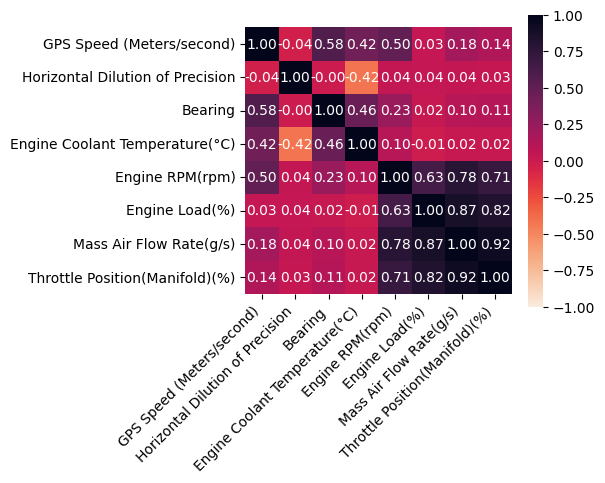

In [6]:
df.columns = df.columns.str.strip()

corr_features = [
    "GPS Speed (Meters/second)",
    "Horizontal Dilution of Precision",
    "Bearing",
    "Engine Coolant Temperature(°C)",
    "Engine RPM(rpm)",
    "Engine Load(%)",
    "Mass Air Flow Rate(g/s)",
    "Throttle Position(Manifold)(%)"
]

corr_df = df[corr_features].corr(method="pearson")

plt.figure(figsize=(6,5))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="rocket_r",   # similar reddish palette
    vmin=-1, vmax=1,
    square=True,
    fmt=".2f"
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
df_features = df[list(features.values())].copy()
print(f"Dataset: {df_features.shape} | Features: {list(features.values())}")

Dataset: (1356, 4) | Features: ['Engine RPM(rpm)', 'Engine Load(%)', 'Mass Air Flow Rate(g/s)', 'Throttle Position(Manifold)(%)']


In [8]:
if USE_SMOOTH_LOAD:
    df['Engine Load Smoothed'] = (
        df[features['load']].rolling(5, center=True).mean().bfill().ffill()
    )
    load_source_col = 'Engine Load Smoothed'
    print("✅ Using smoothed Engine Load as target.")
else:
    load_source_col = features['load']
    print("✅ Using raw Engine Load as target.")

✅ Using smoothed Engine Load as target.


In [9]:
scaler_minmax = MinMaxScaler()
scaler_robust = RobustScaler()

# RPM and MAF with MinMax
df_features[[features["rpm"], features["maf"]]] = scaler_minmax.fit_transform(
    df_features[[features["rpm"], features["maf"]]]
)

# Load from chosen column, then MinMax
df_features[features["load"]] = scaler_minmax.fit_transform(
    df[[load_source_col]]
)

# Throttle with Robust
df_features[features["throttle"]] = scaler_robust.fit_transform(
    df_features[[features["throttle"]]]
)

print("✅ Scaling complete.")

✅ Scaling complete.


In [10]:
X_cluster = df_features[list(features.values())].values
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_cluster)
df_features["cluster"] = clusters

unique, counts = np.unique(clusters, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))

Cluster sizes: {np.int32(0): np.int64(471), np.int32(1): np.int64(885)}


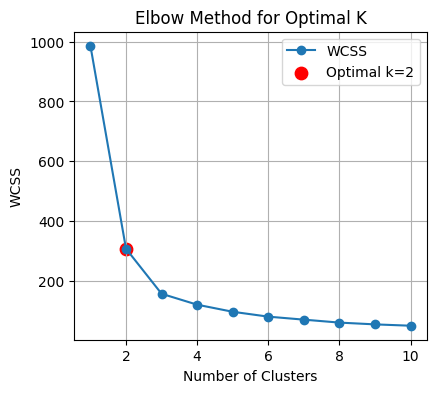

In [11]:
wcss = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_cluster)
    wcss.append(km.inertia_)

optimal_k = 2  # from paper / metrics

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(K_range, wcss, marker='o', label='WCSS')
plt.scatter(optimal_k, wcss[optimal_k-1], color='red', s=80, label=f'Optimal k={optimal_k}')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.grid(True)

In [12]:
def create_sequences(data, seq_length=30, target_idx=1):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length, target_idx])
    return np.array(xs), np.array(ys)

# Base feature matrix (rpm, load, maf, throttle)
base_seq_data = df_features[list(features.values())].values

# Option: add cluster as extra feature
if USE_CLUSTER_AS_FEATURE:
    seq_data_full = np.concatenate([base_seq_data, clusters.reshape(-1, 1)], axis=1)
    target_idx = list(features.values()).index(features["load"])  # still column 1
    print("✅ Using cluster id as additional feature (single global LSTM).")
else:
    seq_data_full = base_seq_data
    target_idx = 1
    print("✅ Will train separate LSTMs per cluster.")

✅ Using cluster id as additional feature (single global LSTM).


In [13]:
X_all, y_all = create_sequences(seq_data_full, seq_length=SEQ_LEN, target_idx=target_idx)
sequence_clusters = clusters[SEQ_LEN:]  # if you need them later
print(f"✅ Sequences: X_all={X_all.shape}, y_all={y_all.shape}")

✅ Sequences: X_all=(1326, 30, 5), y_all=(1326,)


In [14]:
N = X_all.shape[0]
train_size = int(TRAIN_RATIO * N)

X_train, X_test = X_all[:train_size], X_all[train_size:]
y_train, y_test = y_all[:train_size], y_all[train_size:]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (1060, 30, 5) (1060,)
Test : (266, 30, 5) (266,)


In [15]:
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1))

def eval_model(model, X_te, y_te_orig):
    y_pred_scaled = model.predict(X_te, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    mae  = mean_absolute_error(y_te_orig, y_pred)
    mse  = mean_squared_error(y_te_orig, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_te_orig, y_pred)
    return mae, mse, rmse, r2

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

n_features = X_train.shape[2]

model_prop = Sequential([
    LSTM(76, return_sequences=True, activation='tanh', input_shape=(SEQ_LEN, n_features)),
    Dropout(0.2),
    LSTM(76, activation='tanh'),
    Dropout(0.5),
    Dense(1)
])
model_prop.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')

es_prop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

hist_prop = model_prop.fit(
    X_train, y_train_scaled,
    epochs=MAX_EPOCHS,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es_prop],
    verbose=0
)

mae_p, mse_p, rmse_p, r2_p = eval_model(model_prop, X_test, y_test)
print(f"Proposed: MAE={mae_p:.4f}, MSE={mse_p:.4f}, RMSE={rmse_p:.4f}, R2={r2_p:.4f}")

Proposed: MAE=0.0465, MSE=0.0033, RMSE=0.0578, R2=0.9356


In [17]:
model_lstm = Sequential([
    LSTM(48, activation='tanh', input_shape=(SEQ_LEN, n_features)),
    Dropout(0.4),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')

es_lstm = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

hist_lstm = model_lstm.fit(
    X_train, y_train_scaled,
    epochs=300,             # shorter training
    batch_size=64,
    validation_split=0.2,
    callbacks=[es_lstm],
    verbose=0
)

mae_l, mse_l, rmse_l, r2_l = eval_model(model_lstm, X_test, y_test)
print(f"LSTM only: MAE={mae_l:.4f}, MSE={mse_l:.4f}, RMSE={rmse_l:.4f}, R2={r2_l:.4f}")

LSTM only: MAE=0.0598, MSE=0.0051, RMSE=0.0714, R2=0.9020


In [20]:
model_gru = Sequential([
    GRU(32,                      # fewer units than LSTM
        activation='tanh',
        recurrent_dropout=0.3,   # extra regularization inside GRU
        input_shape=(SEQ_LEN, n_features)),
    Dropout(0.5),                # stronger dropout
    Dense(1)
])
model_gru.compile(optimizer=Adam(learning_rate=0.0003),  # slightly higher LR
                  loss='mse')

# very small patience + fewer epochs so it stops early
es_gru = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

hist_gru = model_gru.fit(
    X_train, y_train_scaled,
    epochs=200,                  # fewer epochs than LSTM
    batch_size=64,
    validation_split=0.2,
    callbacks=[es_gru],
    verbose=0
)

mae_g, mse_g, rmse_g, r2_g = eval_model(model_gru, X_test, y_test)
print(f"GRU: MAE={mae_g:.4f}, MSE={mse_g:.4f}, RMSE={rmse_g:.4f}, R2={r2_g:.4f}")

GRU: MAE=0.0698, MSE=0.0072, RMSE=0.0847, R2=0.8620


In [19]:
model_rnn = Sequential([
    SimpleRNN(48, activation='tanh', input_shape=(SEQ_LEN, n_features)),
    Dropout(0.4),
    Dense(1)
])
model_rnn.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')

es_rnn = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

hist_rnn = model_rnn.fit(
    X_train, y_train_scaled,
    epochs=300,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es_rnn],
    verbose=0
)

mae_r, mse_r, rmse_r, r2_r = eval_model(model_rnn, X_test, y_test)
print(f"RNN: MAE={mae_r:.4f}, MSE={mse_r:.4f}, RMSE={rmse_r:.4f}, R2={r2_r:.4f}")

RNN: MAE=0.0584, MSE=0.0047, RMSE=0.0688, R2=0.9088


In [ ]:
results = pd.DataFrame({
    "Model": ["Proposed LSTM+K-means", "LSTM only", "GRU", "RNN"],
    "MAE":  [mae_p, mae_l, mae_g, mae_r],
    "MSE":  [mse_p, mse_l, mse_g, mse_r],
    "RMSE": [rmse_p, rmse_l, rmse_g, rmse_r],
    "R2":   [r2_p, r2_l, r2_g, r2_r]
})

print("\nModel comparison:")
print(results.to_markdown(index=False, floatfmt=".4f"))


Model comparison:
| Model                 |    MAE |    MSE |   RMSE |     R2 |
|:----------------------|-------:|-------:|-------:|-------:|
| Proposed LSTM+K-means | 0.0450 | 0.0031 | 0.0558 | 0.9402 |
| LSTM only             | 0.0595 | 0.0051 | 0.0717 | 0.9011 |
| GRU                   | 0.0675 | 0.0068 | 0.0825 | 0.8691 |
| RNN                   | 0.0589 | 0.0050 | 0.0707 | 0.9038 |


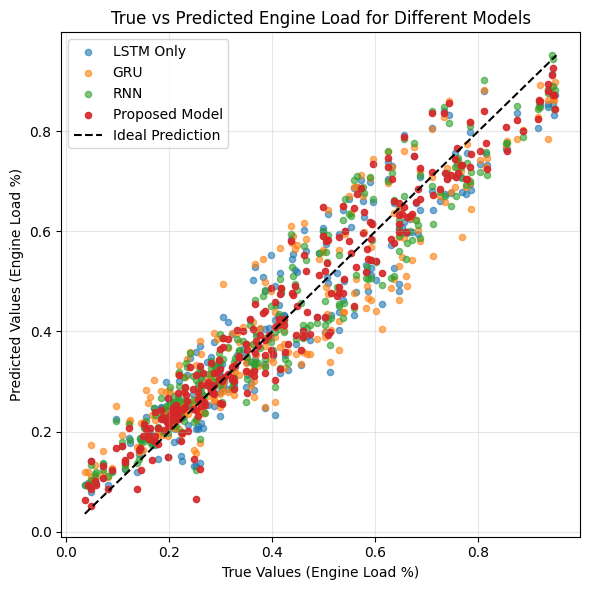

In [ ]:
y_true = np.array(y_test).flatten()

y_pred_prop_scaled = model_prop.predict(X_test, verbose=0)
y_prop = scaler_y.inverse_transform(y_pred_prop_scaled).flatten()

y_pred_lstm_scaled = model_lstm.predict(X_test, verbose=0)
y_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).flatten()

y_pred_gru_scaled = model_gru.predict(X_test, verbose=0)
y_gru = scaler_y.inverse_transform(y_pred_gru_scaled).flatten()

y_pred_rnn_scaled = model_rnn.predict(X_test, verbose=0)
y_rnn = scaler_y.inverse_transform(y_pred_rnn_scaled).flatten()

plt.figure(figsize=(6,6))

plt.scatter(y_true, y_lstm, s=20, alpha=0.6, label='LSTM Only')
plt.scatter(y_true, y_gru,  s=20, alpha=0.6, label='GRU')
plt.scatter(y_true, y_rnn,  s=20, alpha=0.6, label='RNN')
plt.scatter(y_true, y_prop, s=20, alpha=0.9, label='Proposed Model')

# Ideal prediction line
min_val = min(y_true.min(), y_lstm.min(), y_gru.min(), y_rnn.min(), y_prop.min())
max_val = max(y_true.max(), y_lstm.max(), y_gru.max(), y_rnn.max(), y_prop.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Ideal Prediction')

plt.xlabel("True Values (Engine Load %)")
plt.ylabel("Predicted Values (Engine Load %)")
plt.title("True vs Predicted Engine Load for Different Models")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()